In [47]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d,gaussian_filter
import pickle
from skimage import io, filters
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

In [48]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp')
load_dir = os.path.join(warp_directory,  'test.h5')

In [49]:
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def apply_butter_highpass(data, z, cutoff, order, fs):

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    hpf_data = butter_highpass_filter(data[:,:,z, :], cutoff, fs, order)
    return hpf_data

In [50]:
#filter requirements 
order = 2     # ?? wtf is this??
fs = 1.8      # sample rate, Hz
cutoff = 0.01  # desired cutoff frequency of the filter, Hz

In [51]:
%%time
#from warps

with h5py.File(load_dir, 'r') as wf:
        warps = wf['data'][:]
        ts=wf['timestamps'][:]
        dims = np.shape(warps)
        dimsts = np.shape(ts)
        print("Data shape is {} and TimeStamps shape is {}".format(dims, dimsts))
#         hpf_total = []
#         for z in range(dims[-2]):
#             hpf_data = apply_butter_highpass(warps, z, cutoff, order, fs)
#             hpf_total.append(hpf_data)
#         hpf_total = np.array(hpf_total)
#         hpf_total = np.transpose(hpf_total, (1,2,0,3))
#         dims_hpf = np.shape(hpf_total)
#         print("High Pass Filter Data shape is {}".format(dims_hpf))

Data shape is (314, 146, 91, 500) and TimeStamps shape is (314, 146, 91, 500)
CPU times: user 7.99 ms, sys: 4.89 s, total: 4.9 s
Wall time: 12.5 s


In [52]:
# warps = np.rollaxis(warps,0,4)
print(np.shape(warps))

(314, 146, 91, 500)


In [53]:
warps.dtype

dtype('<f4')

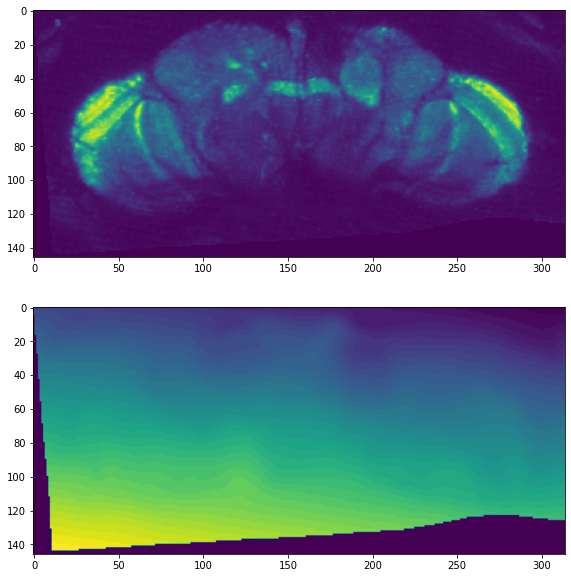

In [54]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(np.max(warps[:,:,20,:],axis=-1).T)
plt.subplot(2,1,2)
plt.imshow(np.max(ts[:,:,20,:],axis=-1).T)

In [55]:
# t_start = 1000
# t_end = 1500
# warps_trunc = warps[...,t_start:t_end]

In [56]:
np.shape(warps)

(314, 146, 91, 500)

In [57]:
%%time
warps_blur=[]
for i in range(np.shape(warps)[-1]):
    warps_temp = gaussian_filter(warps[...,i], sigma=2)
    warps_blur.append(warps_temp)
warps_blur=np.asarray(warps_blur)

print(np.shape(warps_blur))

(500, 314, 146, 91)
CPU times: user 44.7 s, sys: 7.89 s, total: 52.6 s
Wall time: 52.6 s


In [58]:
%%time
warps_blur=np.moveaxis(warps_blur,0,-1)
np.shape(warps_blur)
blurred_f = gaussian_filter(warps_blur, sigma=1)
alpha = 30
sharp=warps_blur + alpha * (warps_blur - blurred_f)

CPU times: user 40.9 s, sys: 11.4 s, total: 52.4 s
Wall time: 52.4 s


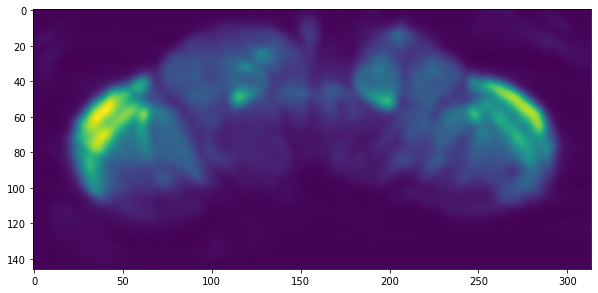

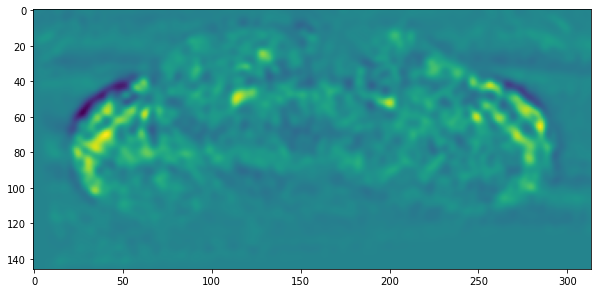

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(warps_blur[:,:,20,100].T)
plt.figure(figsize=(10,10))
plt.imshow(sharp[:,:,20,100].T)

In [60]:
#############
#CHANGE THIS#
#############

warp_def=warps_blur

In [61]:
%%time
hpf_total = []
for z in range(dims[-2]):
    hpf_warps = apply_butter_highpass(warp_def, z, cutoff, order, fs)
    hpf_total.append(hpf_warps)
hpf_total = np.array(hpf_total)
hpf_total = np.transpose(hpf_total, (1,2,0,3))
dims_hpfw = np.shape(hpf_total)
print("High Pass Filter Data shape is {}".format(dims_hpfw))

High Pass Filter Data shape is (314, 146, 91, 500)
CPU times: user 42.3 s, sys: 13.5 s, total: 55.8 s
Wall time: 55.8 s


In [62]:
lpf_total = warp_def-hpf_total
print(np.shape(lpf_total))

(314, 146, 91, 500)


In [63]:
fixed = brainsss.load_fda_meanbrain()
fixed

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [64]:
np.min(fixed.numpy()) #where all vals are 0 set to 0 in df

0.0

In [65]:
dff=hpf_total/(lpf_total-lpf_total.min()+100)

In [66]:
dff.mean()

0.00036129114435253814

In [67]:
# plt.hist(lpf_total.flatten(), bins=50)

In [68]:
dff=np.where(fixed.numpy()[...,None]>0.1, dff, 0)

#dff=np.nan_to_num(dff)


In [69]:
dff.max()

1.732115072774681

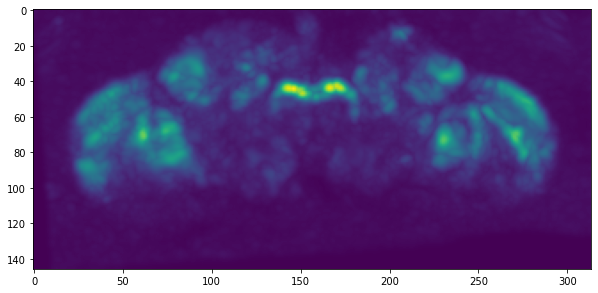

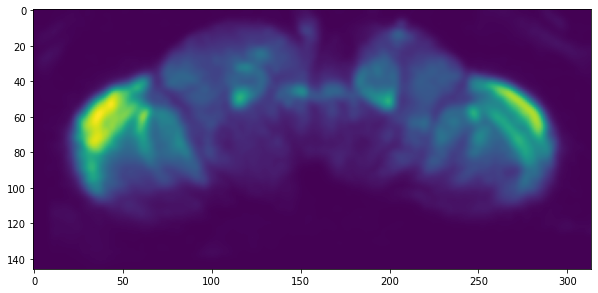

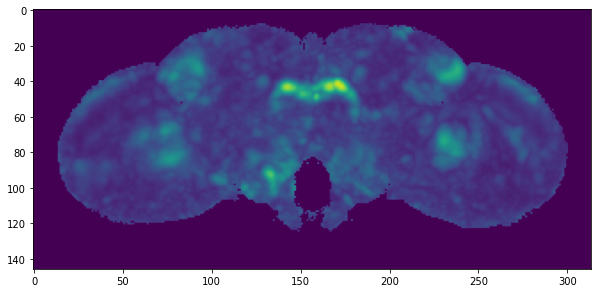

In [70]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(warps[:,:,20,:], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(hpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(lpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(dff[:,:,20, :], axis=-1).T, vmax=1,vmin=0)

In [71]:
brain=dff

In [72]:
shape=np.shape(brain)
print(shape)

(314, 146, 91, 500)


In [73]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX', 'speed']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

loading photodiode data... done


In [74]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val=None):
    traces = []
    for i in range(len(stim_times)):
        if val != None:
            trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        else:
            trace = fictrac[stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [75]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
stim_time = 100
# window = np.arange(-pre_window,post_window)

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac['Y'], starts_loom, pre_window, post_window)

In [76]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    
    plt.figure(figsize=(10,10))
    plt.plot(mean_trace,color='k',linewidth=3)
    plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    plt.axvline(pre_window,color='k',linestyle='--',lw=2)
    plt.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    plt.ylim(-0.5, 3.5);

In [77]:
np.shape(behavior_traces)

(198, 500)

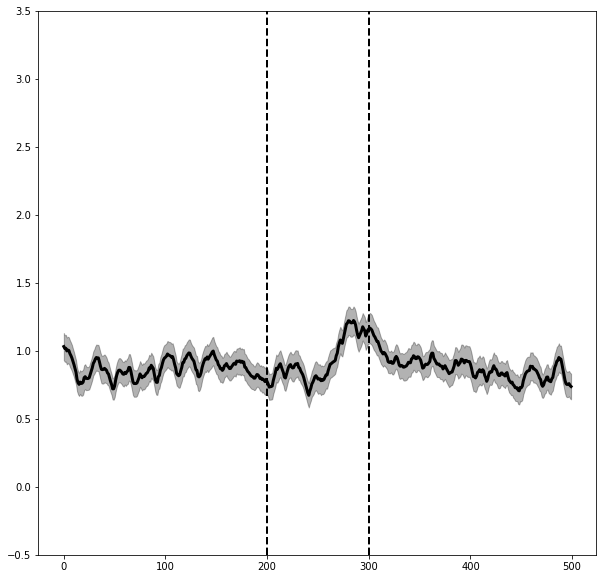

In [78]:
plot_trace(behavior_traces, pre_window, post_window, stim_time)

In [79]:
starts_loom_ms=[n*10 for n in starts_loom]

In [80]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [81]:
bool_starts=(starts_loom_ms>=(np.min(ts))) & (starts_loom_ms<=(np.max(ts)))
starts_loom_ms=np.array(starts_loom_ms)
starts_loom_ms=starts_loom_ms[bool_starts]

In [82]:
starts_loom_ms

array([534420, 541430, 548660, 556540, 564110, 571970, 580310, 587580,
       595370, 603200, 609990, 616640, 624440, 632800, 640090, 647770,
       656090, 663210, 670770, 678830, 687170, 695300, 702230, 710490,
       717920, 725300, 732500, 740060, 747150, 755660, 764010, 772560,
       779650, 787570, 794620])

In [83]:
bins_array=[]
for loom in starts_loom_ms:
#     print(loom)
    start=loom+bin_start
    end=loom+bin_end-bin_size
#     edges=[start,end]
    bins_array.append(start)
    bins_array.append(end)
# bins_test=np.vstack(bins_test)
bins_array=np.array(bins_array)
np.shape(bins_array)

(70,)

In [84]:
bins_array

array([533920, 536320, 540930, 543330, 548160, 550560, 556040, 558440,
       563610, 566010, 571470, 573870, 579810, 582210, 587080, 589480,
       594870, 597270, 602700, 605100, 609490, 611890, 616140, 618540,
       623940, 626340, 632300, 634700, 639590, 641990, 647270, 649670,
       655590, 657990, 662710, 665110, 670270, 672670, 678330, 680730,
       686670, 689070, 694800, 697200, 701730, 704130, 709990, 712390,
       717420, 719820, 724800, 727200, 732000, 734400, 739560, 741960,
       746650, 749050, 755160, 757560, 763510, 765910, 772060, 774460,
       779150, 781550, 787070, 789470, 794120, 796520])

In [85]:
print(np.shape(brain))
print(len(starts_loom_ms))

(314, 146, 91, 500)
35


In [86]:
np.shape(ts)

(314, 146, 91, 500)

In [87]:
%%time
bin_idx = np.digitize(ts, bins_array)

CPU times: user 14.2 s, sys: 10.2 s, total: 24.4 s
Wall time: 24.4 s


In [88]:
np.shape(brain)

(314, 146, 91, 500)

In [89]:
%%time

# make loom-relative version of ts
ts_rel = ts.copy()

# Loop through each loom-containing bin_idx and subtract starts_loom_ms
for i in range(len(starts_loom_ms)):
    # subtract loom onset time for corresponding timestamps
    ts_rel[bin_idx == i*2 + 1] -= starts_loom_ms[i]

# boolean mask of where bin_idx is odd
odd_mask = bin_idx % 2 == 1

# Create flattened (xyz X time) 
n_timesteps = ts_rel.shape[-1]
ts_rel_flat = ts_rel.reshape(-1, n_timesteps)
brain_flat = brain.reshape(-1, n_timesteps)
odd_mask_flat = odd_mask.reshape(-1, n_timesteps)

# Collect ts_rel and brain elements that fall within loom window / bin
within_bin_brain_flat  = [brain_flat[xyz][odd_mask_flat[xyz]] for xyz in range(brain_flat.shape[0])]
within_bin_ts_rel_flat = [ts_rel_flat[xyz][odd_mask_flat[xyz]] for xyz in range(ts_rel_flat.shape[0])]

# Find the maximum length of the sublists
max_len = max(len(sublist) for sublist in within_bin_brain_flat)

# Create a 2D NumPy array filled with np.nan, with the appropriate shape
n_voxels = len(within_bin_brain_flat)
within_bin_brain_flat_np = np.full((n_voxels, max_len), np.nan)
within_bin_ts_rel_flat_np = np.full((n_voxels, max_len), np.nan)

# Populate the array with the values from the original list of lists
for i, (brain_sl, ts_rel_sl) in enumerate(zip(within_bin_brain_flat, within_bin_ts_rel_flat)):
    within_bin_brain_flat_np[i, :len(brain_sl)] = brain_sl
    within_bin_ts_rel_flat_np[i, :len(ts_rel_sl)] = ts_rel_sl

# unflatten
static_brain_shape = brain.shape[:-1]
within_bin_brain_np = within_bin_brain_flat_np.reshape(*static_brain_shape, max_len)
within_bin_ts_rel_np = within_bin_ts_rel_flat_np.reshape(*static_brain_shape, max_len)    

CPU times: user 1min 24s, sys: 18.4 s, total: 1min 43s
Wall time: 1min 43s


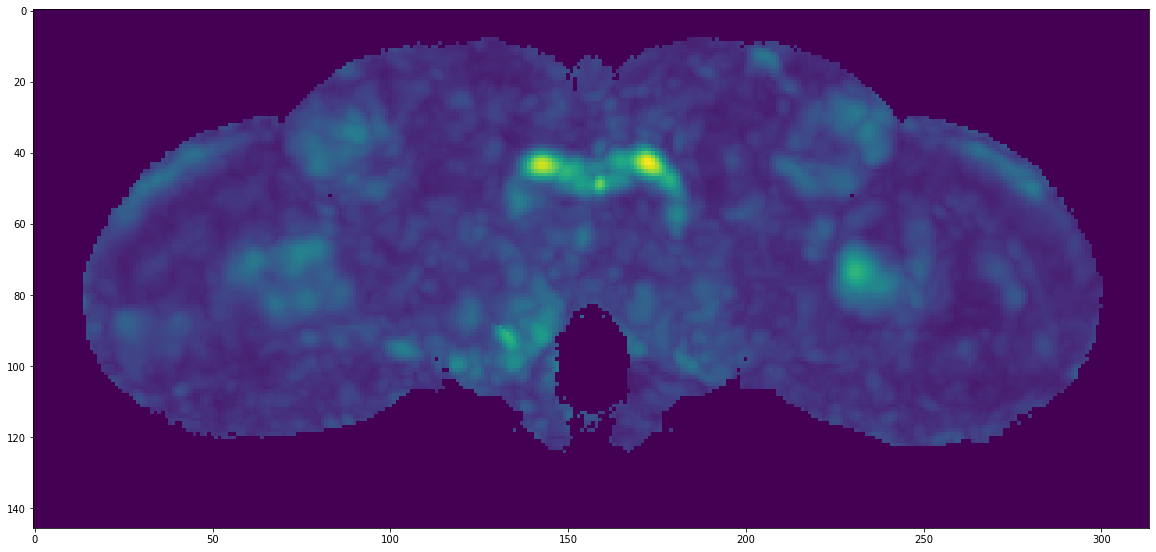

In [90]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(within_bin_brain_np[:,:,20], axis=-1).T)

In [91]:
within_bin_brain_np.shape

(314, 146, 91, 162)

In [95]:
within_bin_ts_rel_np.shape

(314, 146, 91, 162)

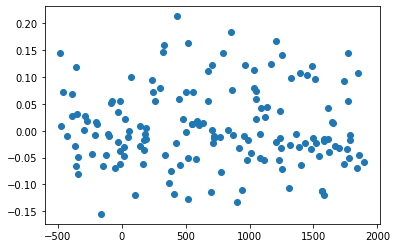

In [96]:
plt.scatter(within_bin_ts_rel_np[100,50,20], within_bin_brain_np[100,50,20])

In [45]:
# %%time

# # make loom-relative version of ts
# ts_rel_w_nan = ts.copy()
# # within_bin_brain_w_nan = brain.copy()

# # Loop through each loom-containing bin_idx and subtract starts_loom_ms
# for i in range(len(starts_loom_ms)):
#     # subtract loom onset time for corresponding timestamps
#     ts_rel_w_nan[bin_idx == i*2 + 1] -= starts_loom_ms[i]

# # boolean mask of where bin_idx is odd
# odd_mask = bin_idx % 2 == 1

# # remove non-bin elements by setting them to nan
# ts_rel_w_nan[~odd_mask] = np.nan
# brain[~odd_mask] = np.nan
# # within_bin_brain_w_nan[~odd_mask] = np.nan

CPU times: user 1min 18s, sys: 30.5 s, total: 1min 48s
Wall time: 1min 48s


In [43]:
brain.nbytes

16687216000

In [44]:
ts.nbytes

8343608000

In [43]:
# %%time
# bin_num={}
# for i in range(np.shape(bins_test)[-1]):
#     if i%2!=0:
#         bool_array=bin_idx==i
#         masked = np.where(brain, bool_array, np.nan)
#         bin_num[i]=masked
# # print(np.shape(masked))

In [44]:
voxel=brain[100,100,40,:]
ts_vox=ts[100,100,40,:]

In [45]:
print(np.shape(voxel))
print(np.shape(ts_vox))


(500,)
(500,)


In [46]:
np.shape(starts_loom_ms)

(35,)

In [47]:
def fun(vox, ts, starts_loom):
    bin_edges=np.linspace(-3000,3000, 21)
    for loom in starts_loom:
        t_rel=ts-loom
        bins=np.digitize(t_rel, bin_edges)
        

In [48]:
%%time

bool_array=bin_idx==61
mid=brain*bool_array
# result=mid[np.nonzero(mid)]
# first_true_index = np.argmax(bool_array)
# last_true_index = np.abs(len(bool_array) - 1 - np.argmax(np.flip(bool_array)))

# result=mid+np.nan*~bool_array


CPU times: user 2.56 s, sys: 3.49 s, total: 6.05 s
Wall time: 6.05 s


In [49]:
brain[bool_array].shape

(19676044,)

In [50]:
# last_true_index=np.max(np.array(np.where(bin_idx==61))[-1,:], axis=-1)

In [51]:
# np.shape(mid[...,first_true_index:last_true_index])

In [52]:
test=np.argwhere(mid != 0)

In [53]:
np.shape(test)

(7277751, 4)

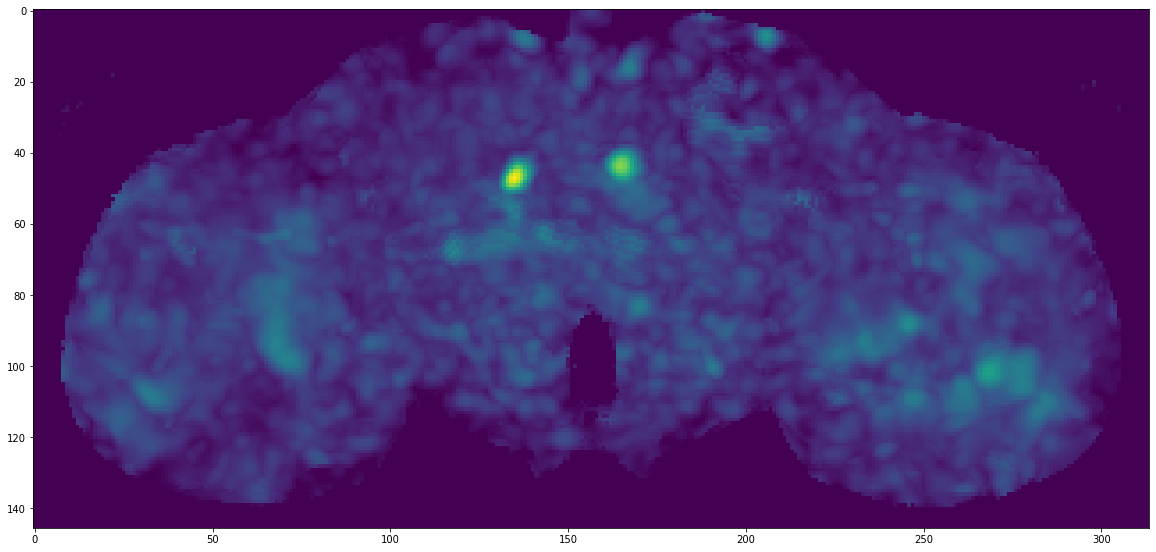

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(np.max(np.mean(mid, axis=-1),axis=-1).T)

In [ ]:
plt.plot(mid[100,100,20,:].T)

In [ ]:
%%time
bin_num=[]
for i in range(np.shape(bins_array)[-1]):
    if i%2!=0:
        bool_array=bin_idx==i
        result=brain*bool_array
        
#         print(i)
#         result=mid+np.nan*~bool_array
# #         masked = brain[bool_array]
#         bin_num[i]=result
# print(np.shape(masked))

In [ ]:
plt.imshow(np.max(masked[...,50,:], axis=-1).T, cmap='seismic')

In [ ]:
z=[]
si=[]
stack=bin_idx[0,0,0,:]
print(np.shape(stack))
for i in range(np.shape(bin_idx)[-1]):
    if stack[i]%2!=0:
        z.append(i)
        si.append(stack[i])

In [ ]:
# u,ind=np.unique(si,return_index=True)

In [ ]:
z

In [ ]:
%%time
locations={}
for i in range(len(bins_test)):
    if i%2!=0:
        location=np.argwhere(bin_idx==i)
        locations[i]=location

In [ ]:
np.shape(locations[1])

In [ ]:
test=tuple(locations[1][7000000,:])
print(brain[test])
test

In [ ]:
brain[120,109,39,3]

In [ ]:
shape=np.shape(all_signals)
STA_brain = []
for z in range(shape[0]):
    all_bin_indicies = []
    for stim_idx in range(len(starts_loom_ms)):
        stim_time = starts_loom_ms[stim_idx]
        stim_centered_bins = neural_bins + stim_time
        bin_indicies = np.digitize(ts[...,z,:] , stim_centered_bins)
        all_bin_indicies.append(bin_indicies)
    all_bin_indicies = np.asarray(all_bin_indicies)
#         print(np.shape(all_bin_indicies))

    avg_neural_across_bins = []
    for bin_num in np.arange(1,len(neural_bins)):
        this_bin_sample_times = list(np.where(all_bin_indicies==bin_num)[1])
        average_neural_in_bin = np.mean(neural_signals[z,:,this_bin_sample_times],axis=0)
        avg_neural_across_bins.append(average_neural_in_bin)
    avg_neural_across_bins = np.asarray(avg_neural_across_bins)
    STA_brain.append(avg_neural_across_bins)
STA_brain = np.asarray(STA_brain)

In [ ]:
STA_brain = make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = ts,
                                   event_times_list = starts_loom_ms, 
                                   neural_bins = neural_bins)

In [ ]:
np.shape(STA_brain)

In [ ]:
STA_brain = np.nan_to_num(STA_brain)

In [ ]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

In [ ]:
%%time
connectivity = grid_to_graph(shape[0],shape[1])
cluster_labels = []
t_shape = shape[3]
for z in range(shape[2]):
    neural_activity = brain[:,:,z,:].reshape(-1, t_shape)
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
    cluster_model.fit(neural_activity)
    cluster_labels.append(cluster_model.labels_)
cluster_labels = np.asarray(cluster_labels)

In [ ]:
%%time
all_signals = []
for z in range(shape[2]):
    neural_activity = brain[:,:,z,:].reshape(-1, t_shape)
    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
        mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    signals = np.asarray(signals)
    all_signals.append(signals)
all_signals = np.asarray(all_signals)

In [ ]:
np.shape(all_signals)

In [ ]:
def STA_supervoxel_to_full_res(STA_brain, cluster_labels,shape):
    n_clusters = STA_brain.shape[2]
    n_tp = STA_brain.shape[1]
    
    reformed_STA_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((n_tp, shape[0]*shape[1]))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[:,cluster_indicies] = STA_brain[z,:,cluster_num,np.newaxis]
        colored_by_betas = colored_by_betas.reshape(n_tp,shape[0],shape[1])
        reformed_STA_brain.append(colored_by_betas)
    return np.asarray(reformed_STA_brain)

In [ ]:
reformed_STA_brain = STA_supervoxel_to_full_res(STA_brain, cluster_labels,shape)

In [ ]:
np.shape(reformed_STA_brain)

In [ ]:
plt.imshow(np.max(reformed_STA_brain[25][:,:,:], axis=0).T,cmap='bone')

In [ ]:
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
np.shape(STA_brain)

In [ ]:
STA_brain = np.moveaxis(STA_brain,0,-1)
np.shape(STA_brain)

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
atlas = brainsss.load_roi_atlas()

In [ ]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = STA_brain[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')